In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import matplotlib.pyplot as plt
import datetime
import metpy
import datetime
import xarray as xr
from pyresample import geometry, grid
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error
import math
from skimage.transform import resize
from skimage.transform import resize_local_mean
import tensorflow as tf
import tensorflow_hub as hub
from skimage.filters import laplace
from skimage.filters import unsharp_mask

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

In [3]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
shape = [500, 500]
pc_extents = [-124.25, 32.25, -114.25, 42.25]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

In [4]:
goes_path = '../landsat_files/'
landsat_path = '../landsat_files/landsat_files/'

day1 = {'goes':'2021240', 'landsat':'20210828'}
day2 = {'goes':'2021247', 'landsat':'20210904'}

a1 = {'day':day1, 'loc':'A', 'lat_0':40.49, 'lon_0':-121.45, 'lat_f':40.650000000000006, 'lon_f':-121.17}
b1 = {'day':day1, 'loc':'B', 'lat_0':39.91, 'lon_0':-120.97, 'lat_f':40.13, 'lon_f':-120.49000000000001}
a2 = {'day':day2, 'loc':'A', 'lat_0':40.707499999999996, 'lon_0':-123.4325, 'lat_f':41.1325, 'lon_f':-122.7075}
b2 = {'day':day2, 'loc':'B', 'lat_0':41.027499999999996, 'lon_0':-123.0925, 'lat_f':41.31250000000001, 'lon_f':-122.6875}


subsets = [a1, b1, a2, b2]

In [5]:
def latslons(subset):
    coords_0 = target_area.get_array_coordinates_from_lonlat(subset['lon_0'], subset['lat_0'])
    coords_0 = (round(coords_0[0]), round(coords_0[1]))
    coords_f = target_area.get_array_coordinates_from_lonlat(subset['lon_f'], subset['lat_f'])
    coords_f = (round(coords_f[0]), round(coords_f[1]))
    subset['lons'] = [coords_0[0], coords_f[0]]
    subset['lats'] = [coords_f[1], coords_0[1]]

In [6]:
def pixshifts(subset):
    
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'red_grid' + subset['loc'] + 'cent0.02deg.npy':
            refimg = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C02_G17_s' + subset['day']['goes']:
            newimg_full = np.load(goes_path + file)
    
    lats = subset['lats']
    lons = subset['lons']

    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    x_add = 0
    y_add = 0
    
    while refimg.shape != newimg.shape: 
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
        
        newimg = newimg_full[lats[0]:lats[1] + x_add, lons[0]:lons[1] + y_add]
    
    lats[1] += x_add
    lons[1] += y_add

    nx = 1
    ny = 1
    x_shift = np.arange(-nx, nx+1)
    y_shift = np.arange(-ny, ny+1)
    scores = []
    
    for x in x_shift:
        for y in y_shift:
            testimg = newimg_full[lats[0]+x:lats[1]+x, lons[0]+y:lons[1]+y]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
    
    max_score = 0
    min_score_index = 0
    
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if abs(score) > abs(max_score):
            max_score = score
            max_score_index = score_index
            
    min_x, min_y, max_score = scores[max_score_index]
    subset['shift'] = [min_x, min_y]

In [202]:
titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']

for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR(subset)
#     applySR_zscore(subset)
    
    
    corrcoeffs = []
    rmses = []

    print('Subset ' + subset['loc'])
    stats = [subset['esrgan_goes_diff'], subset['laplace_goes_diff'], subset['unsharpmask_goes_diff'], subset['control_goes_diff']]
    for n in range(len(titles)):
        vals = results(subset['landsat_diff'], stats[n], titles[n])
        corrcoeffs.append(vals[0])
        rmses.append(vals[1])
        
    subset['corrcoeffs'] = corrcoeffs
    subset['rmses'] = rmses

    print('')

Subset A
ESRGAN correlation coefficient: 0.26707701485638635
ESRGAN rmse: 7.890537339950269
Laplace correlation coefficient: 0.26124980971243006
Laplace rmse: 9.558992313410808
Unsharp Mask correlation coefficient: 0.26221044010277195
Unsharp Mask rmse: 7.827582881483005
Control correlation coefficient: 0.29207432877269457
Control rmse: 7.532847534261337

Subset B
ESRGAN correlation coefficient: 0.3116544548274203
ESRGAN rmse: 10.569526445645623
Laplace correlation coefficient: 0.16881875631328538
Laplace rmse: 14.378933573083984
Unsharp Mask correlation coefficient: 0.2342758102135542
Unsharp Mask rmse: 10.616048155727942
Control correlation coefficient: 0.2927003627087321
Control rmse: 9.810822209882021

Subset A
ESRGAN correlation coefficient: 0.09128243209357062
ESRGAN rmse: 6.067800596213677
Laplace correlation coefficient: 0.15127603626637004
Laplace rmse: 7.606352302605627
Unsharp Mask correlation coefficient: 0.18446488021412244
Unsharp Mask rmse: 5.7266822432871765
Control cor

In [198]:
print('max bt 373 stats \n')

titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']

for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR_max373(subset)
#     applySR_zscore(subset)
    
    
    corrcoeffs = []
    rmses = []

    print('Subset ' + subset['loc'])
    stats = [subset['esrgan_goes_img_103'], subset['laplace_goes_img_103'], subset['unsharpmask_goes_img_103'], subset['control_goes_img_103']]
    for n in range(len(titles)):
        vals = results(subset['landsat_img_103'], stats[n], titles[n])
        corrcoeffs.append(vals[0])
        rmses.append(vals[1])
        
    subset['corrcoeffs'] = corrcoeffs
    subset['rmses'] = rmses

    print('')

max bt 373 stats 

Subset A
ESRGAN correlation coefficient: 0.48421564214617885
ESRGAN rmse: 9.055154813490537
Laplace correlation coefficient: 0.7269331142579772
Laplace rmse: 6.6431836373253645
Unsharp Mask correlation coefficient: 0.7481562300943154
Unsharp Mask rmse: 6.619107529615773
Control correlation coefficient: 0.7557056863296875
Control rmse: 6.610742518943855

Subset B
ESRGAN correlation coefficient: 0.5961417441788531
ESRGAN rmse: 7.921261097771035
Laplace correlation coefficient: 0.8152936753351613
Laplace rmse: 6.05008032847954
Unsharp Mask correlation coefficient: 0.829880286732066
Unsharp Mask rmse: 6.043350079729828
Control correlation coefficient: 0.833012397485375
Control rmse: 6.060764089016903

Subset A
ESRGAN correlation coefficient: 0.31412903076071147
ESRGAN rmse: 5.862526517342069
Laplace correlation coefficient: 0.4643051281997302
Laplace rmse: 4.553278187266358
Unsharp Mask correlation coefficient: 0.5006732217592316
Unsharp Mask rmse: 4.482683053763142
Cont

In [35]:
print('10.3 micron stats \n')

titles = ['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control']

for subset in subsets:
    latslons(subset)
    pixshifts(subset)
    applySR(subset)
#     applySR_zscore(subset)
    
    
    corrcoeffs = []
    rmses = []

    print('Subset ' + subset['loc'])
    stats = [subset['esrgan_goes_img_103'], subset['laplace_goes_img_103'], subset['unsharpmask_goes_img_103'], subset['control_goes_img_103']]
    for n in range(len(titles)):
        vals = results(subset['landsat_img_103'], stats[n], titles[n])
        corrcoeffs.append(vals[0])
        rmses.append(vals[1])
        
    subset['corrcoeffs'] = corrcoeffs
    subset['rmses'] = rmses

    print('')

10.3 micron stats 

Subset A
ESRGAN correlation coefficient: 0.4893849701674524
ESRGAN rmse: 9.018710199612679
Laplace correlation coefficient: 0.5153322313065714
Laplace rmse: 7.137610955752901
Unsharp Mask correlation coefficient: 0.6578423730885345
Unsharp Mask rmse: 6.770014389384307
Control correlation coefficient: 0.7224234211898887
Control rmse: 6.652809144008722

Subset B
ESRGAN correlation coefficient: 0.6020898368673226
ESRGAN rmse: 7.893396303618934
Laplace correlation coefficient: 0.6487838863224611
Laplace rmse: 6.513296068426407
Unsharp Mask correlation coefficient: 0.7698060111114605
Unsharp Mask rmse: 6.1486846281471275
Control correlation coefficient: 0.8156018501183661
Control rmse: 6.071707772394119

Subset A
ESRGAN correlation coefficient: 0.3121620810478052
ESRGAN rmse: 5.888328505015115
Laplace correlation coefficient: 0.31103484754063243
Laplace rmse: 5.107841672014995
Unsharp Mask correlation coefficient: 0.4187742375323412
Unsharp Mask rmse: 4.6660768314809955


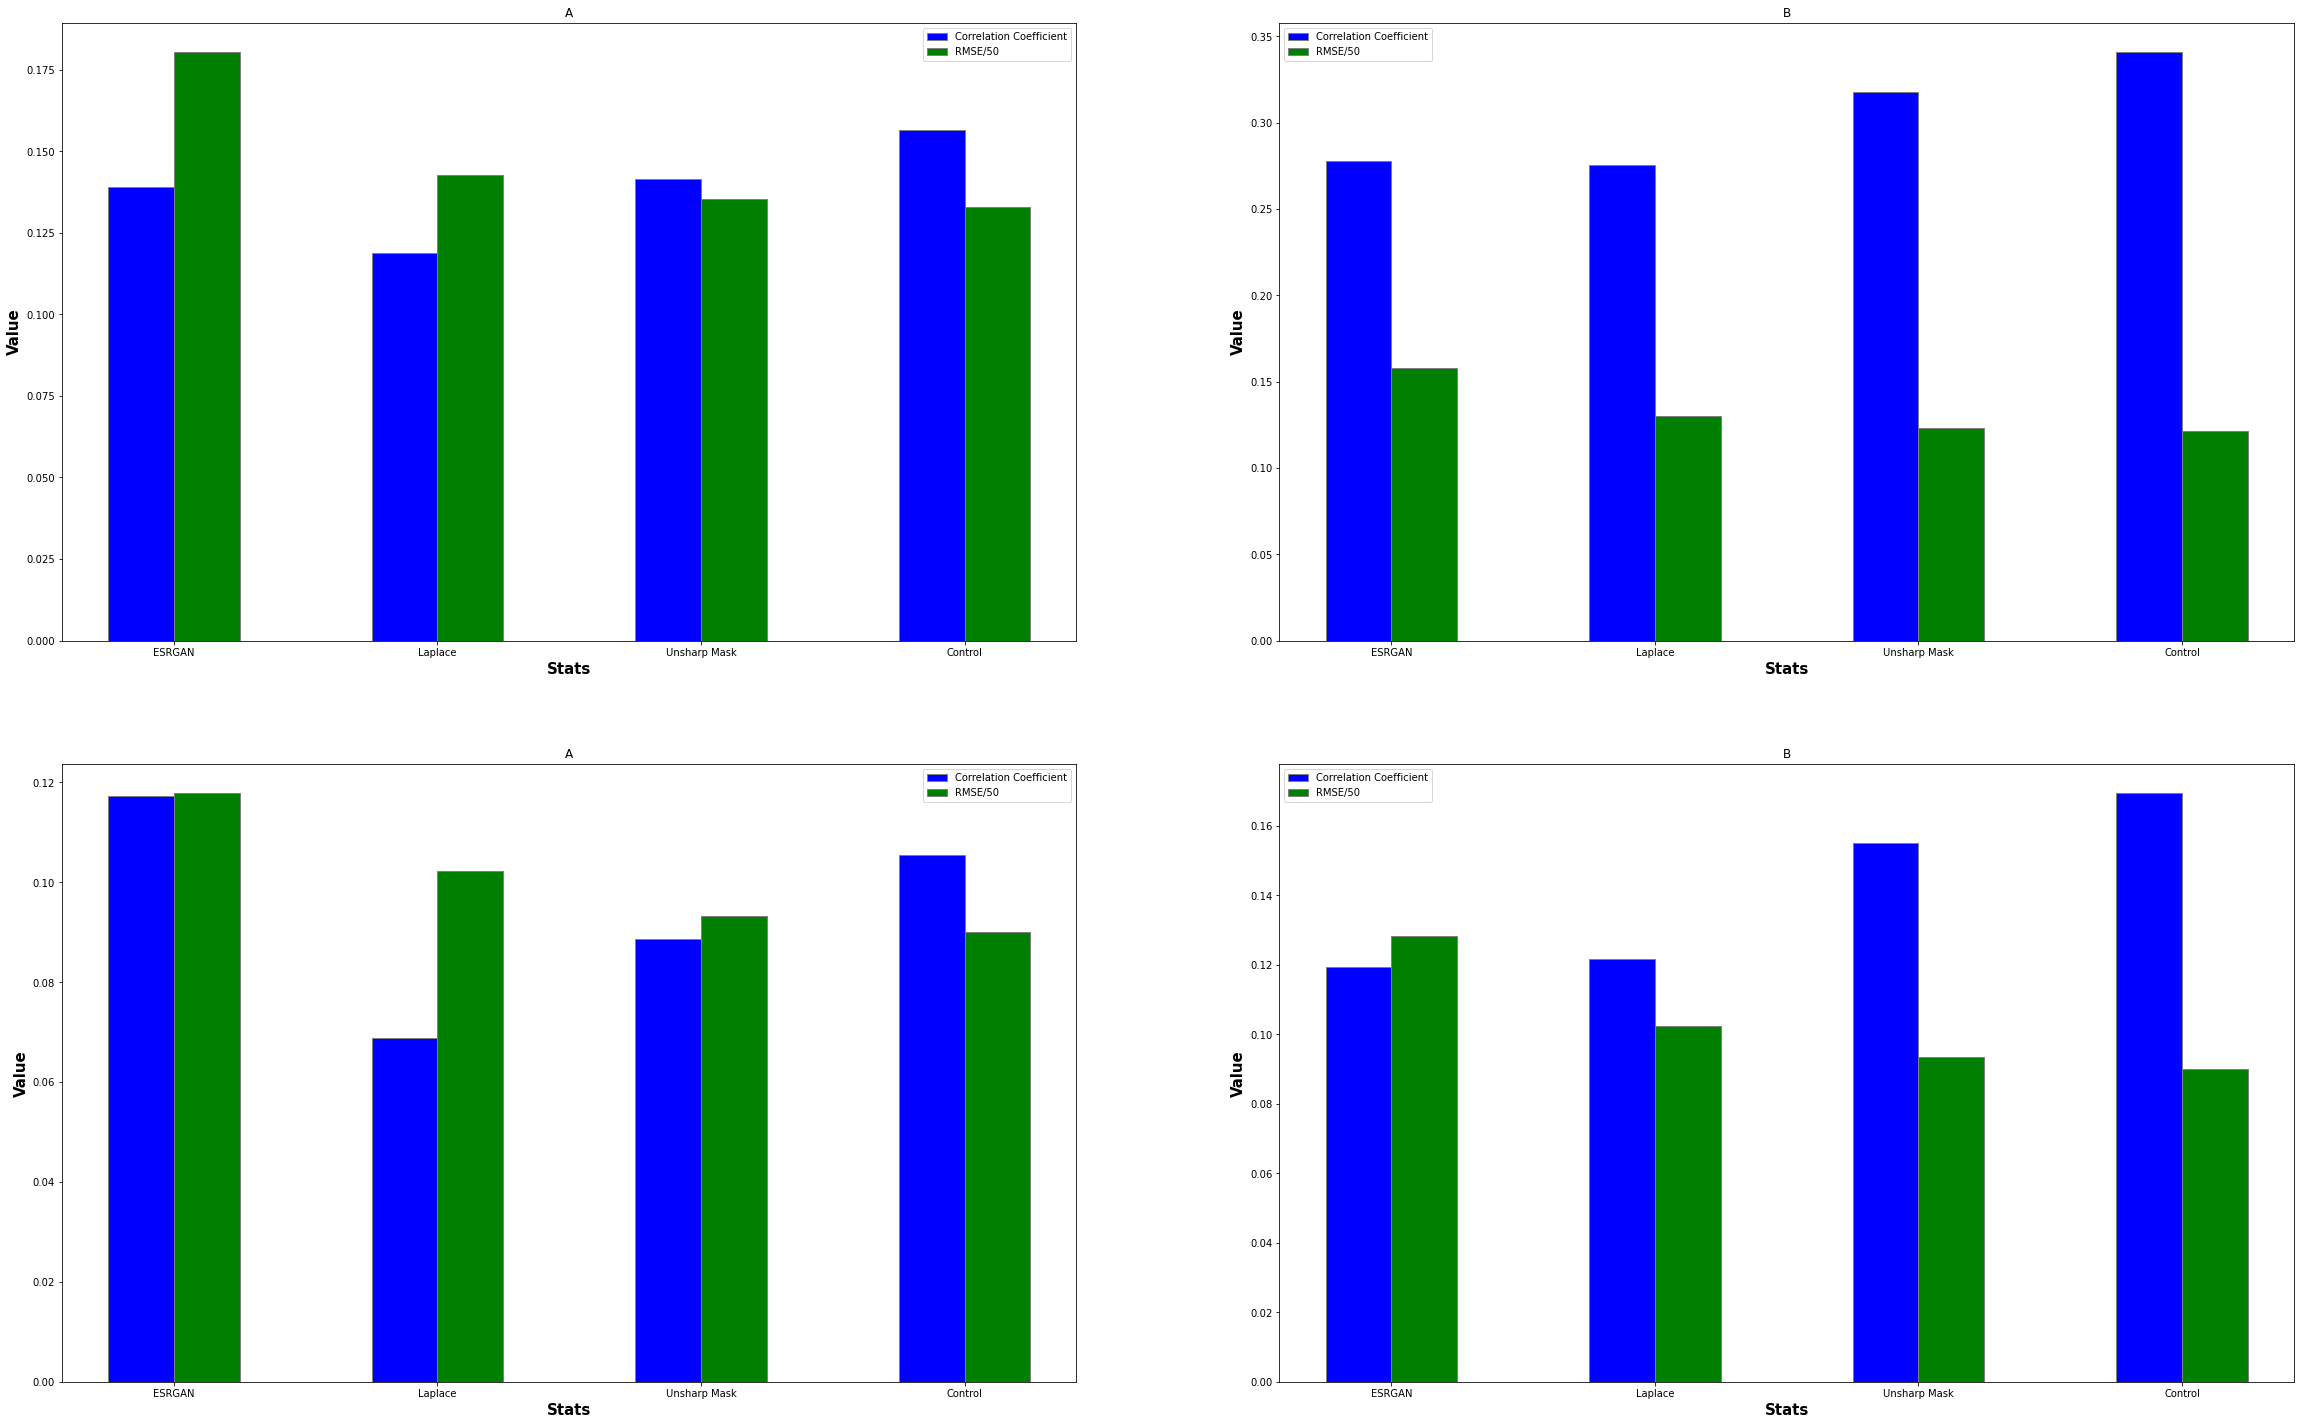

In [108]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(40, 25))
axs = [ax1, ax2]
X = np.arange(4)
barWidth = 0.25

for n in range(2):
    ax = axs[n]
    
    subset = subsets[2*n]
    ax[0].bar(X + 0.00, subset['corrcoeffs'], color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
    ax[0].bar(X + 0.25, subset['rmses'], color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')
    ax[0].set_title(subset['loc'])
    ax[0].set_xlabel('Stats', fontweight ='bold', fontsize = 15)
    ax[0].set_ylabel('Value', fontweight ='bold', fontsize = 15)
    ax[0].set_xticks([r + barWidth/2 for r in range(len(titles))])
    ax[0].set_xticklabels(['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
    ax[0].legend()
    
    subset = subsets[2*n+1]
    ax[1].bar(X + 0.00, subset['corrcoeffs'], color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
    ax[1].bar(X + 0.25, subset['rmses'], color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')
    ax[1].set_title(subset['loc'])
    ax[1].set_xlabel('Stats', fontweight ='bold', fontsize = 15)
    ax[1].set_ylabel('Value', fontweight ='bold', fontsize = 15)
    ax[1].set_xticks([r + barWidth/2 for r in range(len(titles))])
    ax[1].set_xticklabels(['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
    ax[1].legend()

In [16]:
def results(refimg, newimg, title):
    print(title + " correlation coefficient: " + str(np.corrcoef(refimg.ravel(), newimg.ravel())[0, 1]))
    print(title + " rmse: " + str(math.sqrt(np.square(refimg - newimg).mean())))
    return [abs(np.corrcoef(refimg, newimg).mean()), math.sqrt(np.square(refimg - newimg).mean())/50]

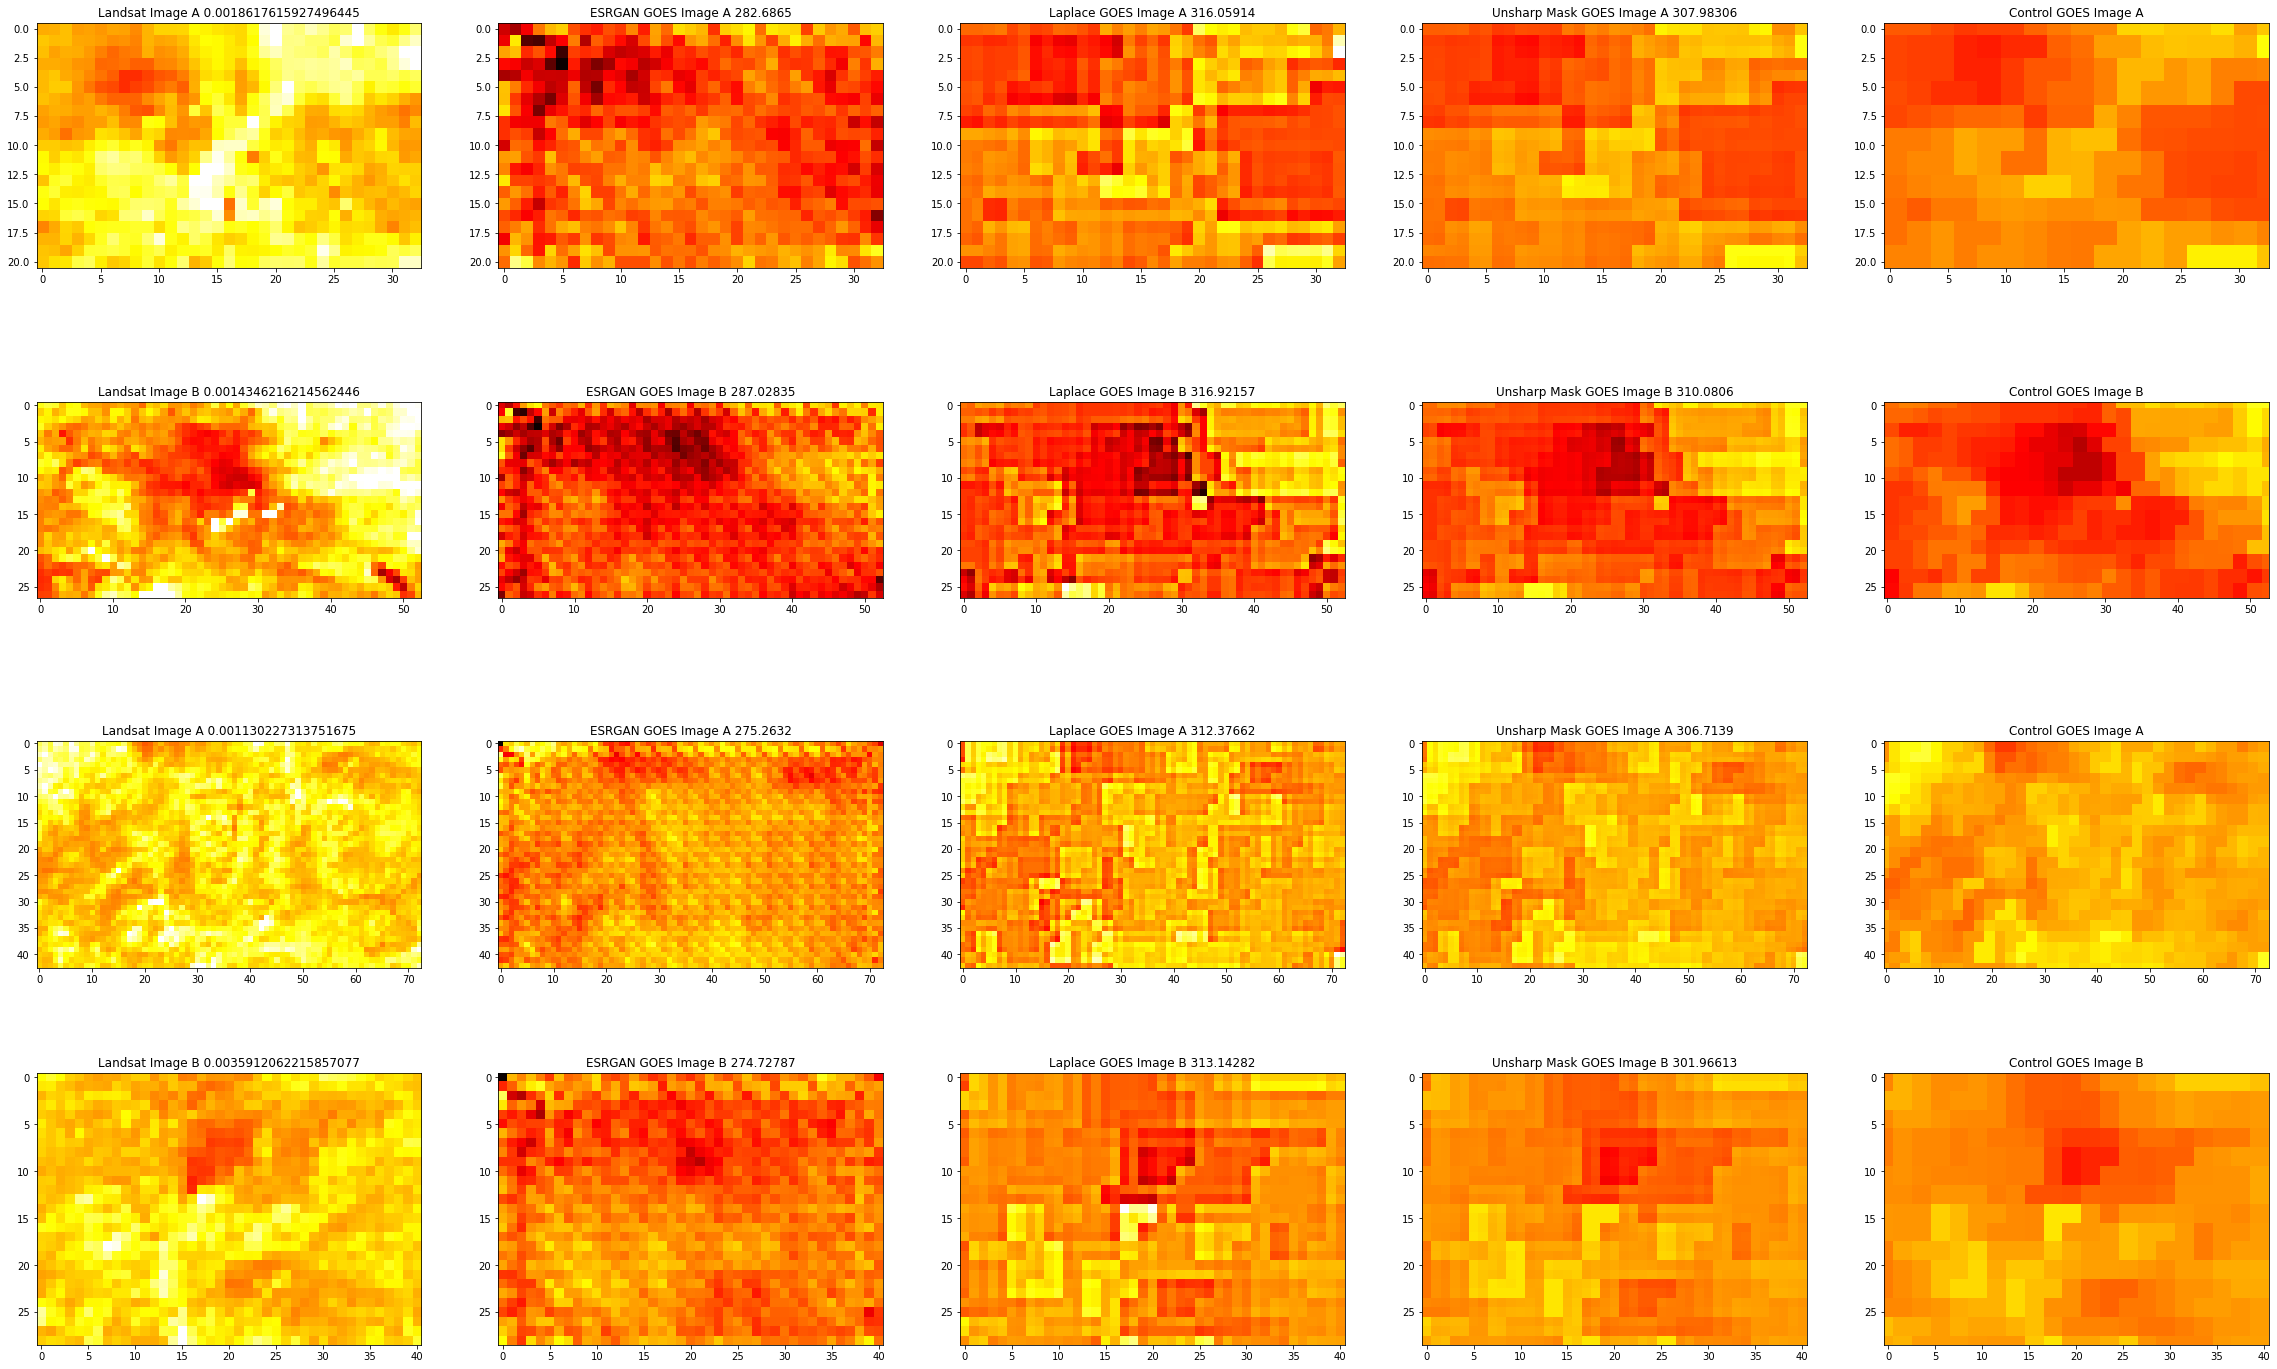

In [104]:
print('10.3 micron')

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 5, figsize=(40, 25))
axs = [ax1, ax2, ax3, ax4]

max_temp = 350
min_temp = 300



for n in range(4):
    ax = axs[n]
    subset = subsets[n]
    
    vals = np.vstack([subset['esrgan_goes_img_103'].ravel(), subset['laplace_goes_img_103'].ravel(), subset['unsharpmask_goes_img_103'].ravel(), subset['control_goes_img_103'].ravel()])
    max_temp = vals.max()
    min_temp = vals.min()
    
    ax[0].imshow(subset['landsat_img_103'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[0].set_title('Landsat Image ' + subset['loc'] + ' ' + str(min(subset['landsat_diff'].ravel())))
    ax[1].imshow(subset['esrgan_goes_img_103'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[1].set_title('ESRGAN GOES Image ' + subset['loc'] + ' ' + str(min(subset['esrgan_goes_img_103'].ravel())))
    ax[2].imshow(subset['laplace_goes_img_103'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[2].set_title('Laplace GOES Image ' + subset['loc'] + ' ' + str(max(subset['laplace_goes_img_103'].ravel())))
    ax[3].imshow(subset['unsharpmask_goes_img_103'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[3].set_title('Unsharp Mask GOES Image ' + subset['loc'] + ' ' + str(max(subset['unsharpmask_goes_img_103'].ravel())))
    ax[4].imshow(subset['control_goes_img_103'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[4].set_title('Control GOES Image ' + subset['loc'])

Sanity Check

1. Scatter plot of individual wavelengths for landsat vs goes at goes native
2. 3 scatter plots (for algorithms) vs landsat

Upsampling looks more blocky than a linear interpolation should (check control)

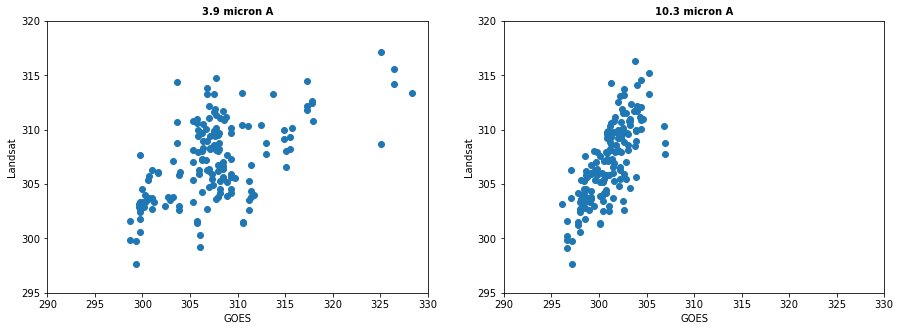

In [111]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

fontsize = 10
    
subset = subsets[0]
    
ax[0].scatter(subset['original_goes_img_039'], subset['original_landsat_img_039'])
ax[0].set_title('3.9 micron ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[1].scatter(subset['original_goes_img_103'], subset['original_landsat_img_103'])
ax[1].set_title('10.3 micron ' + subset['loc'], fontsize = fontsize, fontweight ='bold')
    
for n in range(2):
    ax[n].set_xlabel('GOES', fontsize = fontsize)
    ax[n].set_ylabel('Landsat', fontsize = fontsize)
    ax[n].set_xlim(290, 330)
    ax[n].set_ylim(295, 320)

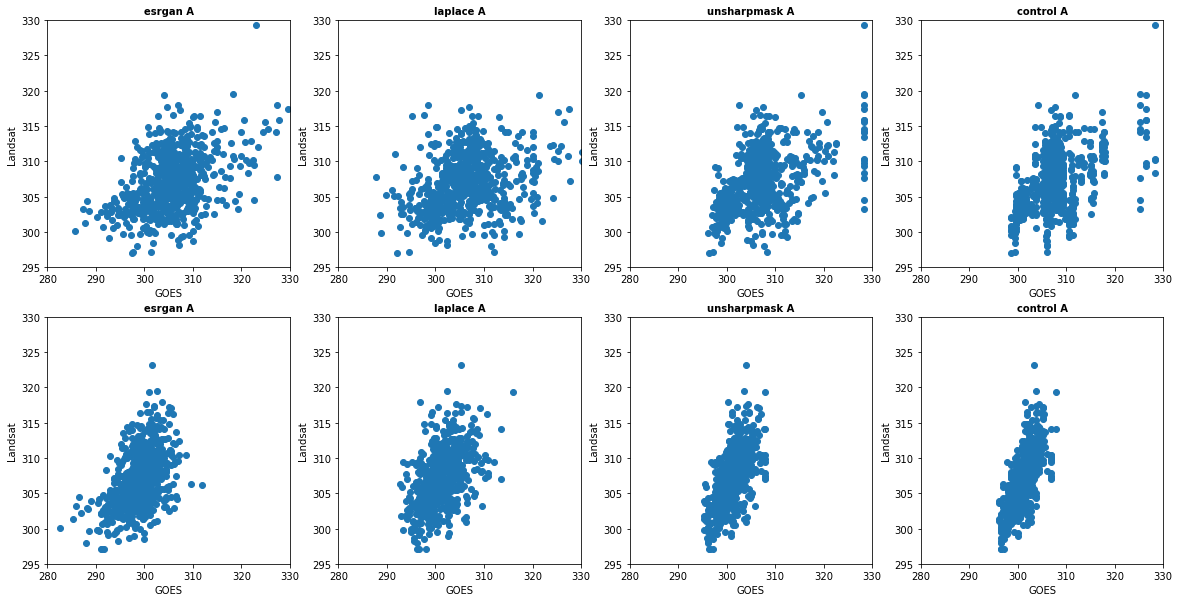

In [117]:
f, (ax1, ax2) = plt.subplots(2, 4, figsize=(20, 10))

fontsize = 10
    
subset = subsets[0]
    
ax1[0].scatter(subset['esrgan_goes_img_039'], subset['landsat_img_039'])
ax1[0].set_title('esrgan ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax1[1].scatter(subset['laplace_goes_img_039'], subset['landsat_img_039'])
ax1[1].set_title('laplace ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax1[2].scatter(subset['unsharpmask_goes_img_039'], subset['landsat_img_039'])
ax1[2].set_title('unsharpmask ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax1[3].scatter(subset['control_goes_img_039'], subset['landsat_img_039'])
ax1[3].set_title('control ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax2[0].scatter(subset['esrgan_goes_img_103'], subset['landsat_img_103'])
ax2[0].set_title('esrgan ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax2[1].scatter(subset['laplace_goes_img_103'], subset['landsat_img_103'])
ax2[1].set_title('laplace ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax2[2].scatter(subset['unsharpmask_goes_img_103'], subset['landsat_img_103'])
ax2[2].set_title('unsharpmask ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax2[3].scatter(subset['control_goes_img_103'], subset['landsat_img_103'])
ax2[3].set_title('control ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

for n in range(4):
    ax1[n].set_xlabel('GOES', fontsize = fontsize)
    ax1[n].set_ylabel('Landsat', fontsize = fontsize)
    ax2[n].set_xlabel('GOES', fontsize = fontsize)
    ax2[n].set_ylabel('Landsat', fontsize = fontsize)
    ax1[n].set_xlim(280, 330)
    ax1[n].set_ylim(295, 330)
    ax2[n].set_xlim(280, 330)
    ax2[n].set_ylim(295, 330)

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))

fontsize = 10
    
subset = subsets[0]
    
ax[0].scatter(subset['esrgan_goes_diff'], subset['landsat_diff'])
ax[0].set_title('esrgan ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[1].scatter(subset['laplace_goes_diff'], subset['landsat_diff'])
ax[1].set_title('laplace ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[2].scatter(subset['unsharpmask_goes_diff'], subset['landsat_diff'])
ax[2].set_title('unsharpmask ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

ax[3].scatter(subset['control_goes_diff'], subset['landsat_diff'])
ax[3].set_title('control ' + subset['loc'], fontsize = fontsize, fontweight ='bold')

for n in range(4):
    ax[n].set_xlabel('GOES', fontsize = fontsize)
    ax[n].set_ylabel('Landsat', fontsize = fontsize)
    ax[n].set_xlim(-10, 50)
    ax[n].set_ylim(0, 7)

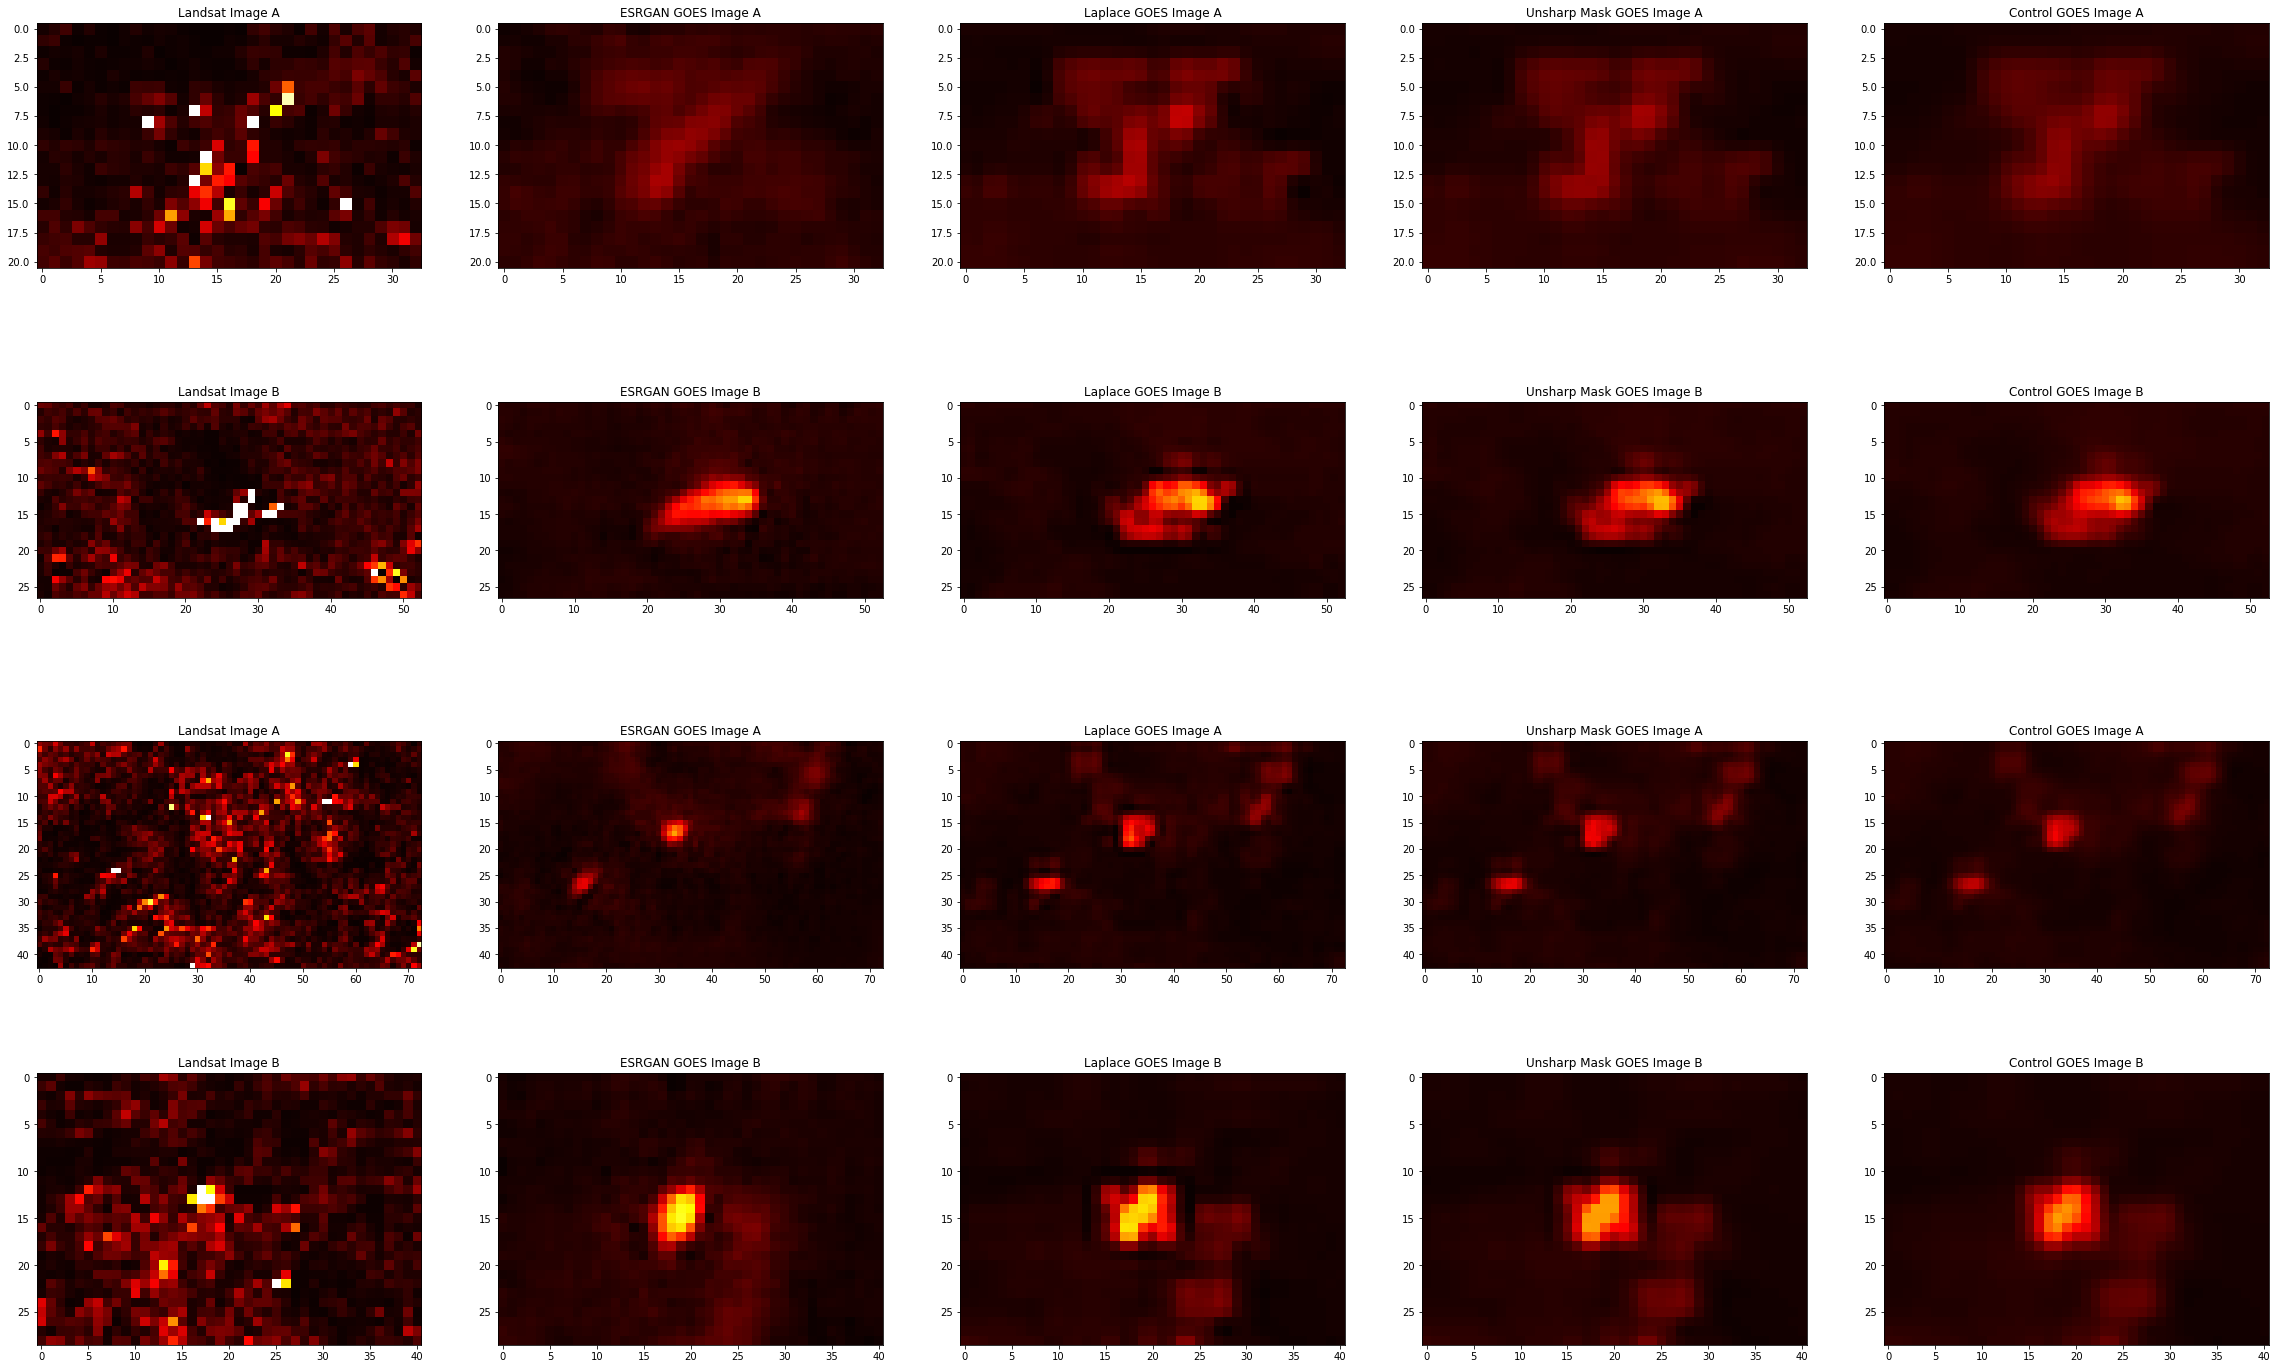

In [199]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 5, figsize=(40, 25))
axs = [ax1, ax2, ax3, ax4]

max_temp = 100
min_temp = 0

for n in range(4):
    ax = axs[n]
    subset = subsets[n]
    
    ax[0].imshow(100*subset['landsat_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[0].set_title('Landsat Image ' + subset['loc'])
    ax[1].imshow(subset['esrgan_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[1].set_title('ESRGAN GOES Image ' + subset['loc'])
    ax[2].imshow(subset['laplace_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[2].set_title('Laplace GOES Image ' + subset['loc'])
    ax[3].imshow(subset['unsharpmask_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[3].set_title('Unsharp Mask GOES Image ' + subset['loc'])
    ax[4].imshow(subset['control_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[4].set_title('Control GOES Image ' + subset['loc'])

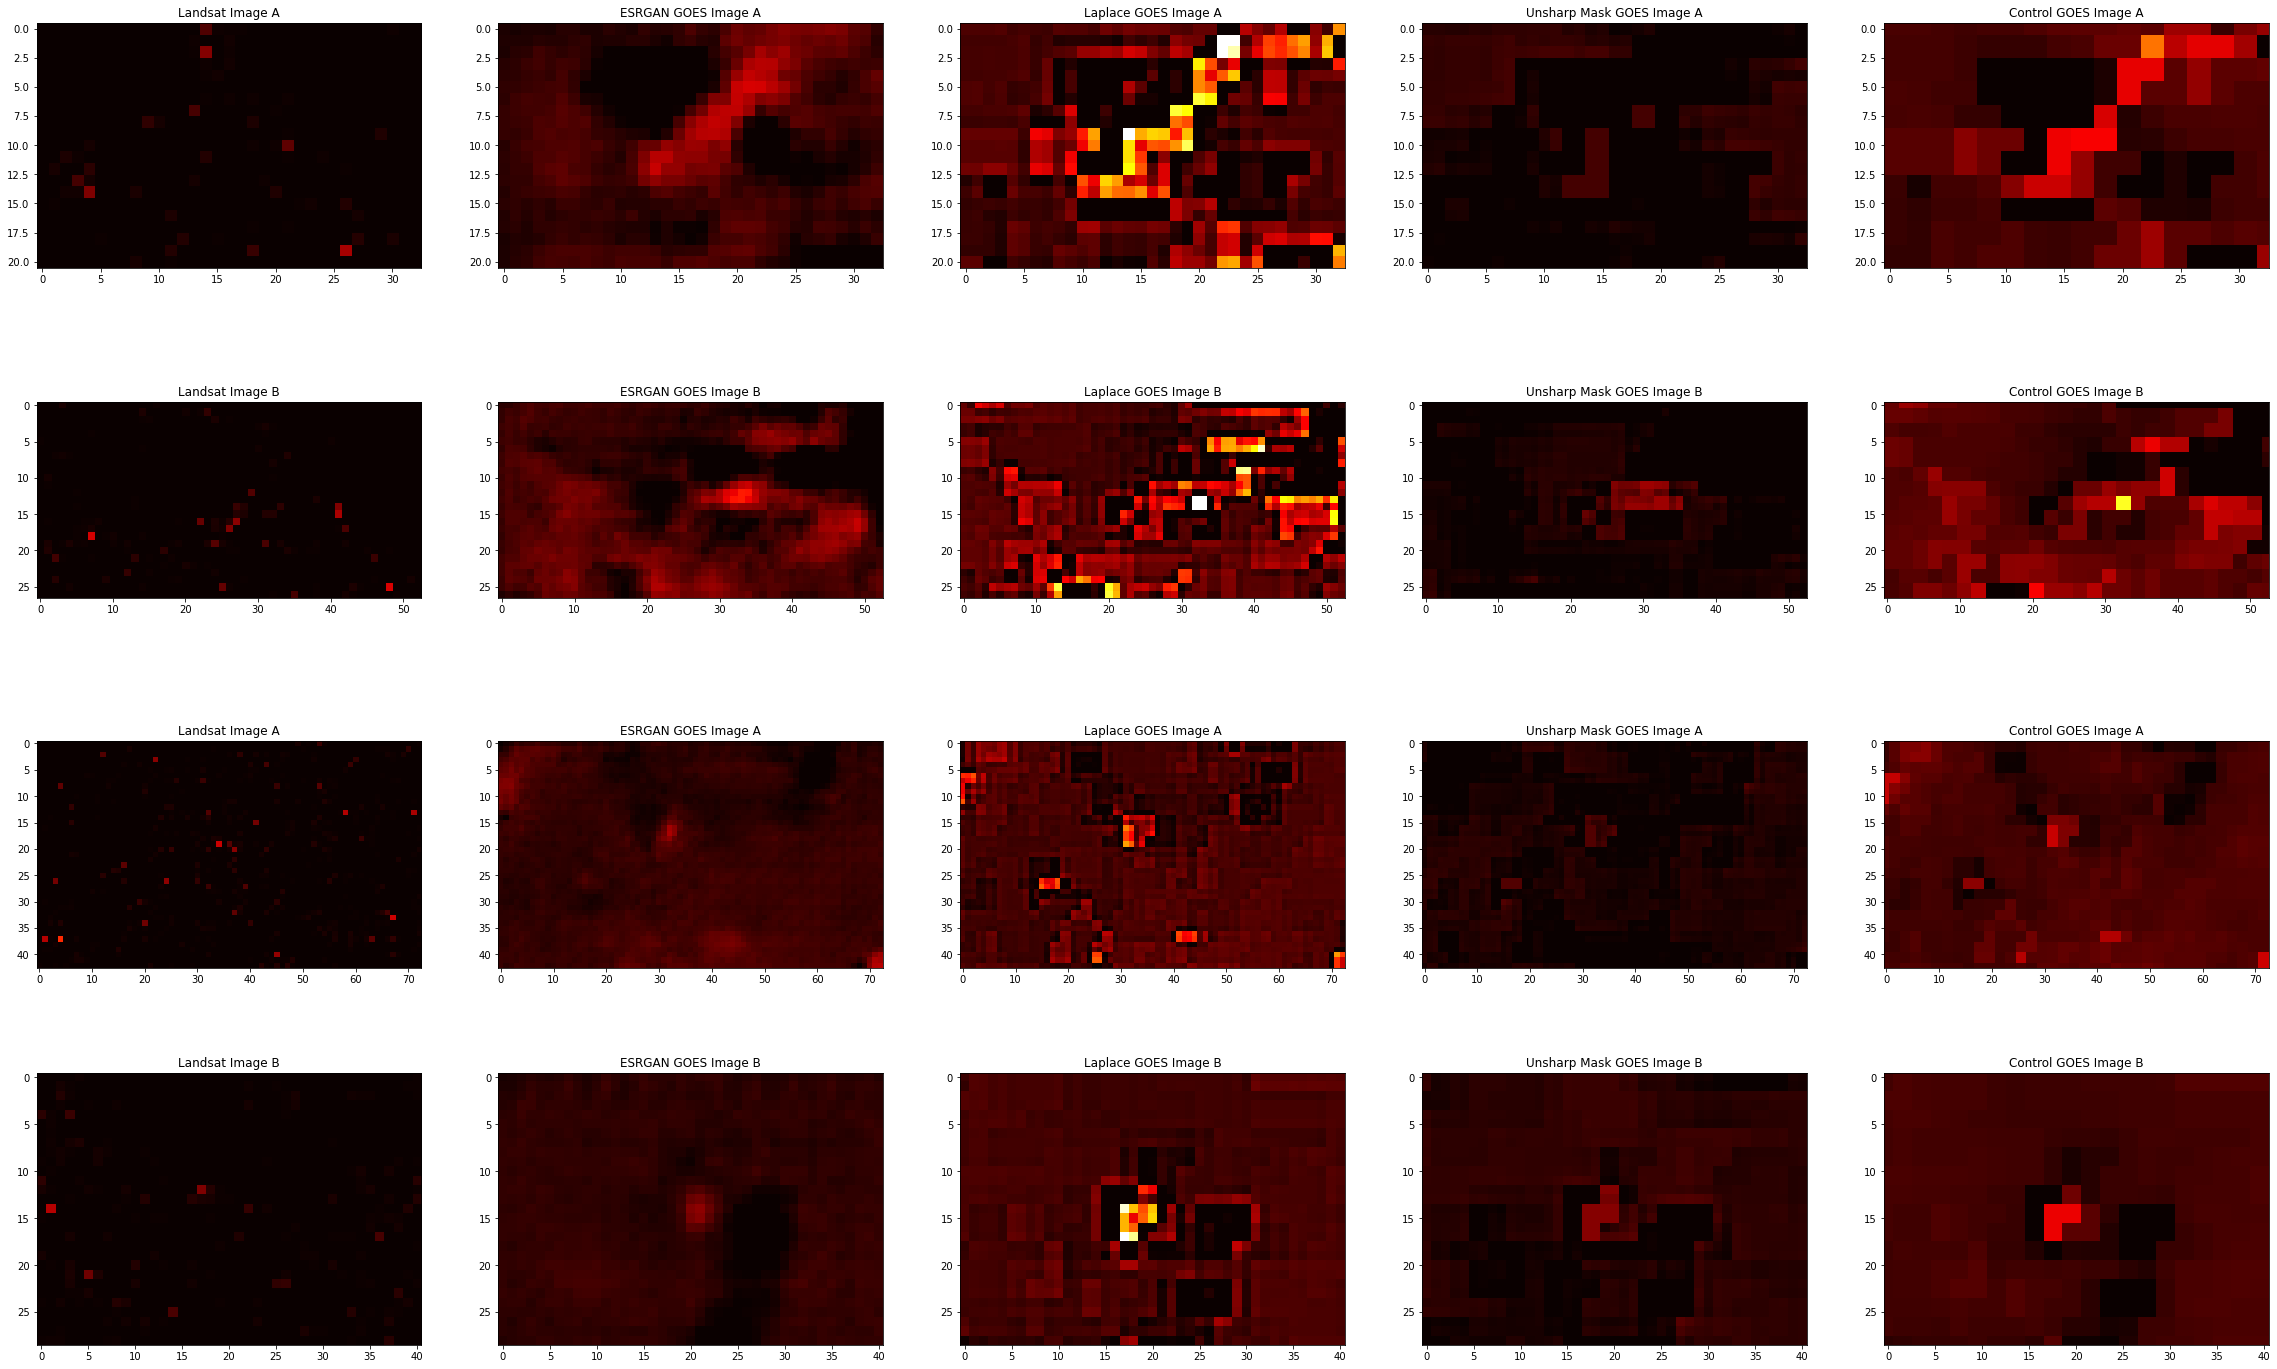

In [50]:
print('z scores')

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 5, figsize=(40, 25))
axs = [ax1, ax2, ax3, ax4]

max_temp = 10
min_temp = 0

for n in range(4):
    ax = axs[n]
    subset = subsets[n]
    
    ax[0].imshow(subset['landsat_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[0].set_title('Landsat Image ' + subset['loc'])
    ax[1].imshow(subset['esrgan_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[1].set_title('ESRGAN GOES Image ' + subset['loc'])
    ax[2].imshow(subset['laplace_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[2].set_title('Laplace GOES Image ' + subset['loc'])
    ax[3].imshow(subset['unsharpmask_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[3].set_title('Unsharp Mask GOES Image ' + subset['loc'])
    ax[4].imshow(subset['control_goes_diff'], vmin = min_temp, vmax = max_temp, cmap='hot')
    ax[4].set_title('Control GOES Image ' + subset['loc'])

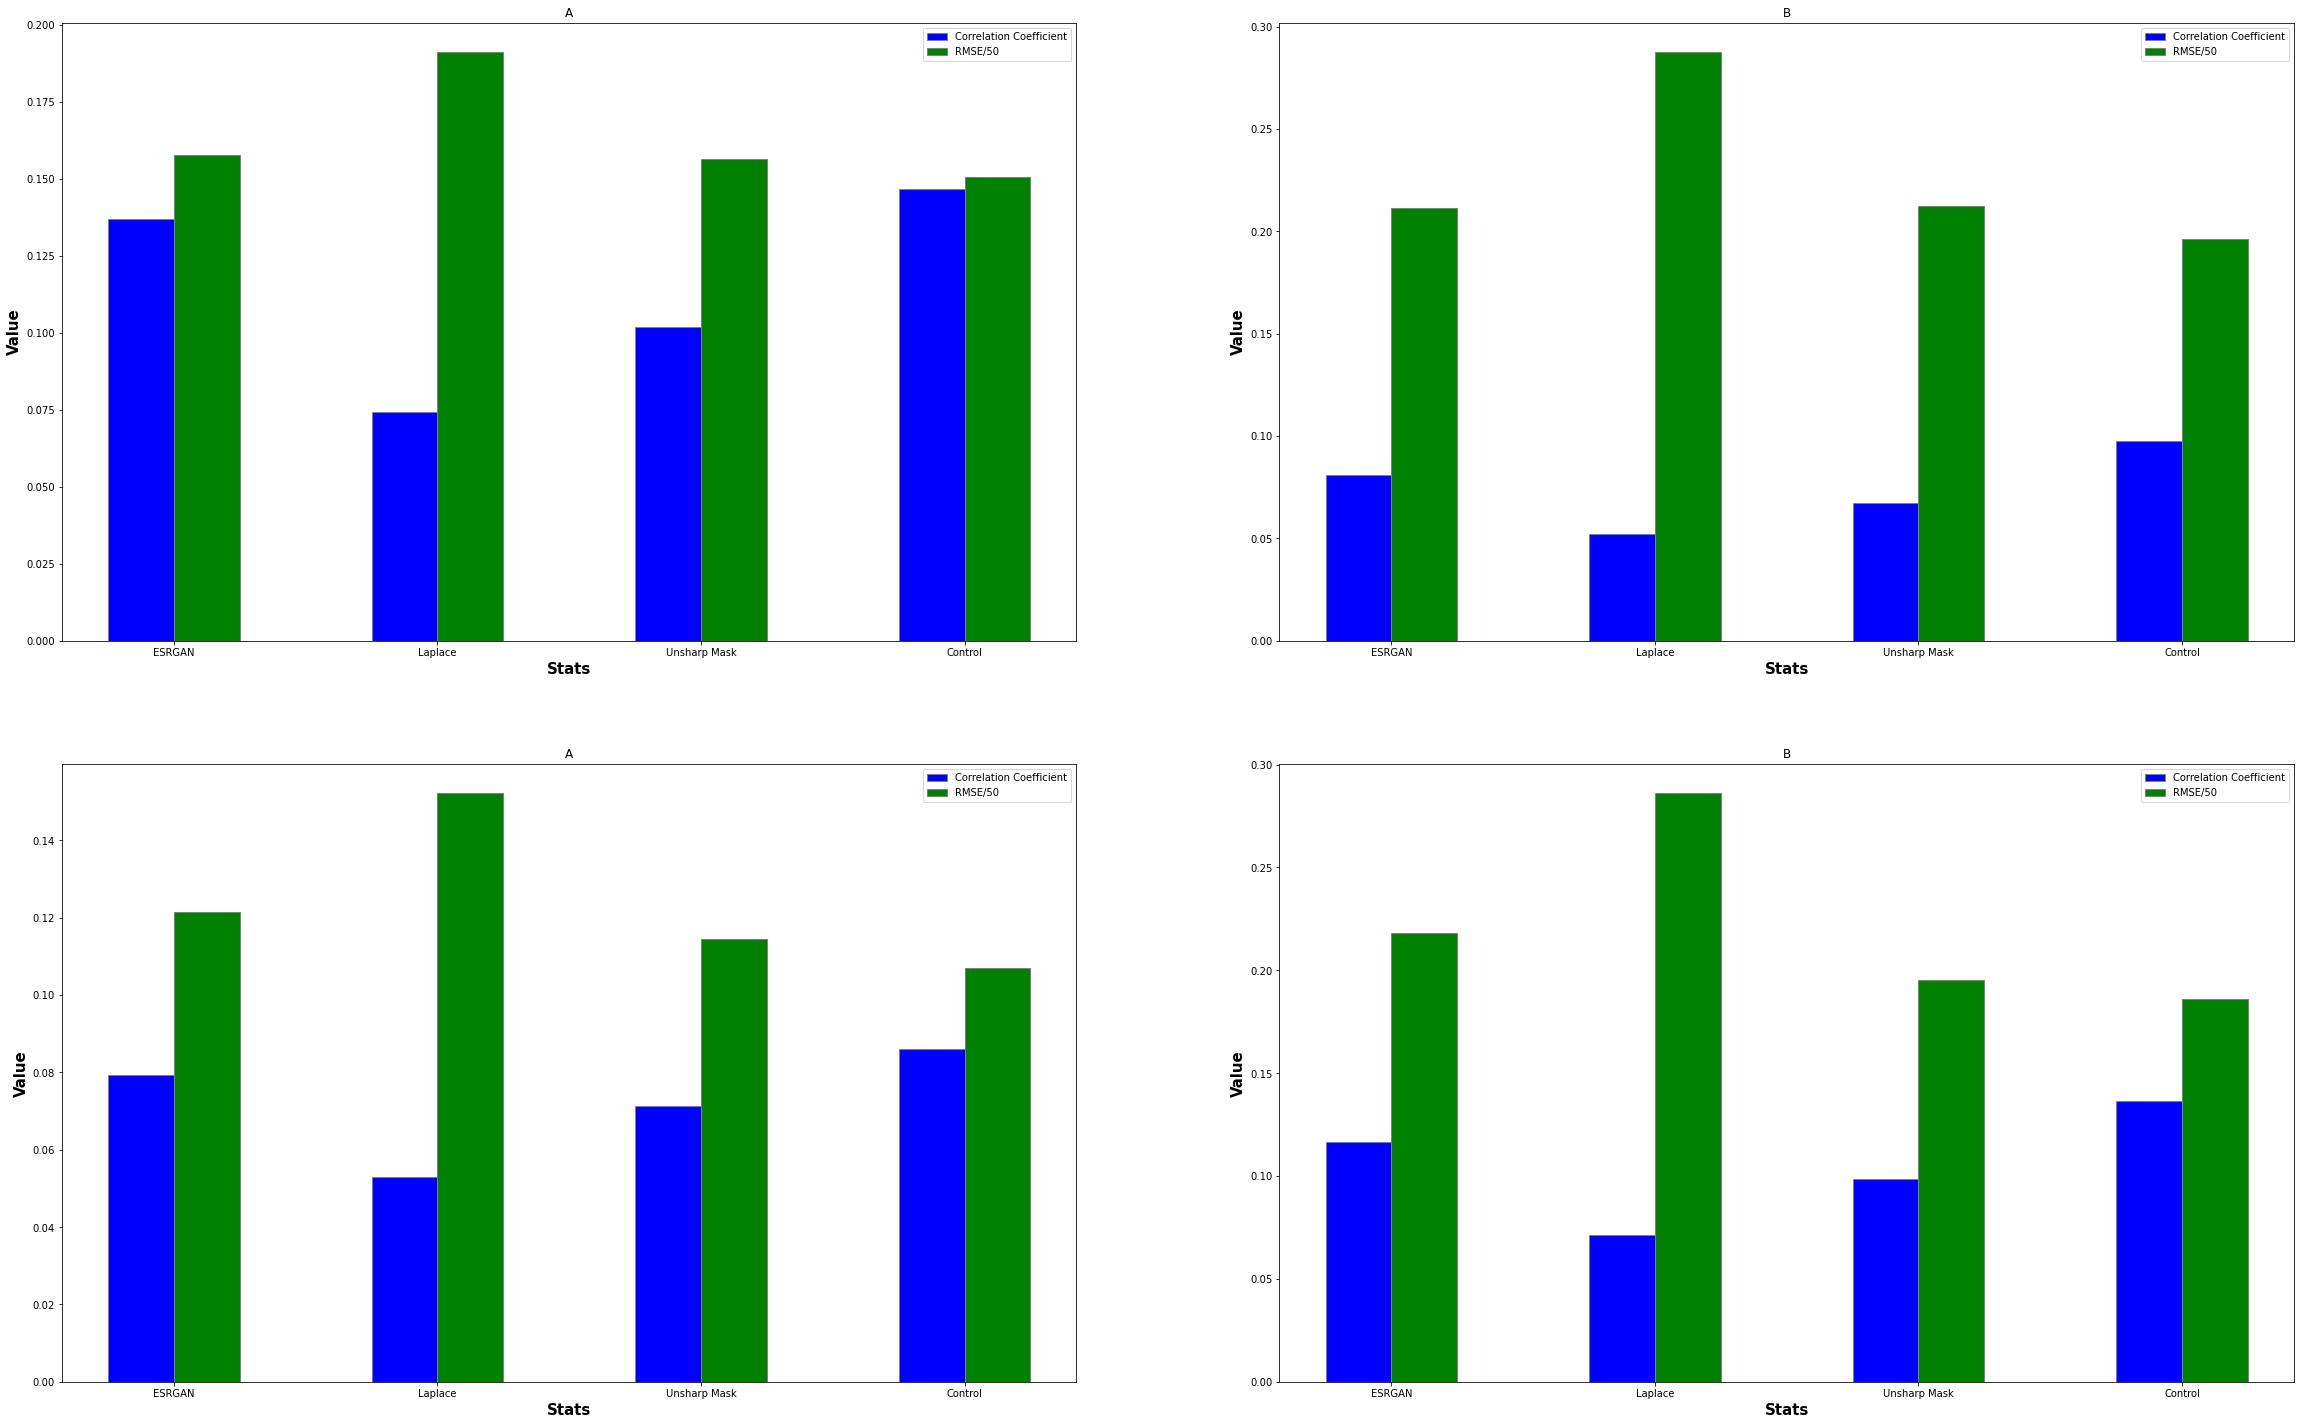

In [57]:
f, (ax1, ax2) = plt.subplots(2, 2, figsize=(40, 25))
axs = [ax1, ax2]
X = np.arange(4)
barWidth = 0.25

for n in range(2):
    ax = axs[n]
    
    subset = subsets[2*n]
    ax[0].bar(X + 0.00, subset['corrcoeffs'], color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
    ax[0].bar(X + 0.25, subset['rmses'], color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')
    ax[0].set_title(subset['loc'])
    ax[0].set_xlabel('Stats', fontweight ='bold', fontsize = 15)
    ax[0].set_ylabel('Value', fontweight ='bold', fontsize = 15)
    ax[0].set_xticks([r + barWidth/2 for r in range(len(titles))])
    ax[0].set_xticklabels(['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
    ax[0].legend()
    
    subset = subsets[2*n+1]
    ax[1].bar(X + 0.00, subset['corrcoeffs'], color ='b', width = barWidth, edgecolor ='grey', label ='Correlation Coefficient')
    ax[1].bar(X + 0.25, subset['rmses'], color ='g', width = barWidth, edgecolor ='grey', label ='RMSE/50')
    ax[1].set_title(subset['loc'])
    ax[1].set_xlabel('Stats', fontweight ='bold', fontsize = 15)
    ax[1].set_ylabel('Value', fontweight ='bold', fontsize = 15)
    ax[1].set_xticks([r + barWidth/2 for r in range(len(titles))])
    ax[1].set_xticklabels(['ESRGAN', 'Laplace', 'Unsharp Mask', 'Control'])
    ax[1].legend()

In [8]:
def applySR_zscore(subset):
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_039 = z_score(np.flipud(np.load(landsat_path + file)))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_103 = z_score(np.flipud(np.load(landsat_path + file)))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_039 = z_score(np.flipud(np.load(landsat_path + file)))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_103 = z_score(np.flipud(np.load(landsat_path + file)))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C07_G17_s' + subset['day']['goes']:
            goes_img_039 = z_score(np.load(goes_path + file))
        if file[:34] == 'OR_ABI-L1b-RadC-M6C14_G17_s' + subset['day']['goes']:
            goes_img_103 = z_score(np.load(goes_path + file))
            
    new_landsat_diff = new_landsat_img_039 - new_landsat_img_103
    subset['landsat_diff'] = new_landsat_diff

    goes_img_expanded_039 = expand(landsat_img_039, goes_img_039, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    goes_img_expanded_103 = expand(landsat_img_103, goes_img_103, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])

    esrgan_goes_img_039 = shiftPixels(new_landsat_img_039, esrgan_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    esrgan_goes_img_103 = shiftPixels(new_landsat_img_103, esrgan_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['esrgan_goes_diff'] = esrgan_goes_img_039 - esrgan_goes_img_103

    laplace_goes_img_039 = shiftPixels(new_landsat_img_039, laplace_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    laplace_goes_img_103 = shiftPixels(new_landsat_img_103, laplace_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['laplace_goes_diff'] = laplace_goes_img_039 - laplace_goes_img_103

    unsharpmask_goes_img_039 = shiftPixels(new_landsat_img_039, unsharpmask_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    unsharpmask_goes_img_103 = shiftPixels(new_landsat_img_103, unsharpmask_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['unsharpmask_goes_diff'] = unsharpmask_goes_img_039 - unsharpmask_goes_img_103

    control_goes_img_039 = shiftPixels(new_landsat_img_039, control_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    control_goes_img_103 = shiftPixels(new_landsat_img_103, control_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['control_goes_diff'] = control_goes_img_039 - control_goes_img_103

In [59]:
def applySR_max373(subset):
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_103 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_103 = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C07_G17_s' + subset['day']['goes']:
            goes_img_039 = np.load(goes_path + file)
        if file[:34] == 'OR_ABI-L1b-RadC-M6C14_G17_s' + subset['day']['goes']:
            goes_img_103 = np.load(goes_path + file)
            
    new_landsat_diff = new_landsat_img_039 - new_landsat_img_103
    subset['landsat_diff'] = new_landsat_diff
    subset['landsat_img_039'] = new_landsat_img_039
    subset['landsat_img_103'] = new_landsat_img_103

    goes_img_expanded_039 = expand(landsat_img_039, goes_img_039, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    goes_img_expanded_103 = expand(landsat_img_103, goes_img_103, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])

    esrgan_goes_img_039 = shiftPixels(new_landsat_img_039, esrgan_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    esrgan_goes_img_039[esrgan_goes_img_039 > 373] = 373
    esrgan_goes_img_103 = shiftPixels(new_landsat_img_103, esrgan_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['esrgan_goes_diff'] = esrgan_goes_img_039 - esrgan_goes_img_103
    subset['esrgan_goes_img_039'] = esrgan_goes_img_039
    subset['esrgan_goes_img_103'] = esrgan_goes_img_103

    laplace_goes_img_039 = shiftPixels(new_landsat_img_039, laplace_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    laplace_goes_img_039[laplace_goes_img_039 > 373] = 373
    laplace_goes_img_103 = shiftPixels(new_landsat_img_103, laplace_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['laplace_goes_diff'] = laplace_goes_img_039 - laplace_goes_img_103
    subset['laplace_goes_img_039'] = laplace_goes_img_039
    subset['laplace_goes_img_103'] = laplace_goes_img_103

    unsharpmask_goes_img_039 = shiftPixels(new_landsat_img_039, unsharpmask_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    unsharpmask_goes_img_039[unsharpmask_goes_img_039 > 373] = 373
    unsharpmask_goes_img_103 = shiftPixels(new_landsat_img_103, unsharpmask_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['unsharpmask_goes_diff'] = unsharpmask_goes_img_039 - unsharpmask_goes_img_103
    subset['unsharpmask_goes_img_039'] = unsharpmask_goes_img_039
    subset['unsharpmask_goes_img_103'] = unsharpmask_goes_img_103

    control_goes_img_039 = shiftPixels(new_landsat_img_039, control_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    control_goes_img_103 = shiftPixels(new_landsat_img_103, control_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['control_goes_diff'] = control_goes_img_039 - control_goes_img_103
    subset['control_goes_img_039'] = control_goes_img_039
    control_goes_img_039[control_goes_img_039 > 373] = 373
    subset['control_goes_img_103'] = control_goes_img_103

In [76]:
def applySR(subset):
    for file in os.listdir(landsat_path):
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.02deg.npy':
            landsat_img_103 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT3.9_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_039 = np.flipud(np.load(landsat_path + file))
        if file[17:25] == subset['day']['landsat'] and file[48:] == 'BT10.3_grid' + subset['loc'] + 'cent0.01deg.npy':
            new_landsat_img_103 = np.flipud(np.load(landsat_path + file))

    for file in os.listdir(goes_path):
        if file[:34] == 'OR_ABI-L1b-RadC-M6C07_G17_s' + subset['day']['goes']:
            goes_img_039 = np.load(goes_path + file)
            
        if file[:34] == 'OR_ABI-L1b-RadC-M6C14_G17_s' + subset['day']['goes']:
            goes_img_103 = np.load(goes_path + file)
           
    new_landsat_diff = new_landsat_img_039 - new_landsat_img_103
    subset['landsat_diff'] = new_landsat_diff
    subset['landsat_img_039'] = new_landsat_img_039
    subset['landsat_img_103'] = new_landsat_img_103

    goes_img_expanded_039 = expand(landsat_img_039, goes_img_039, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    goes_img_expanded_103 = expand(landsat_img_103, goes_img_103, subset['shift'][0], subset['shift'][1], subset['lats'], subset['lons'])
    
    subset['original_goes_img_039'] = shiftPixels(landsat_img_039, goes_img_expanded_039, subset['shift'][0], subset['shift'][1])
    subset['original_goes_img_103'] = shiftPixels(landsat_img_103, goes_img_expanded_103, subset['shift'][0], subset['shift'][1])
    subset['original_landsat_img_039'] = landsat_img_039
    subset['original_landsat_img_103'] = landsat_img_103

    esrgan_goes_img_039 = shiftPixels(new_landsat_img_039, esrgan_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    esrgan_goes_img_103 = shiftPixels(new_landsat_img_103, esrgan_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['esrgan_goes_diff'] = esrgan_goes_img_039 - esrgan_goes_img_103
    subset['esrgan_goes_img_039'] = esrgan_goes_img_039
    subset['esrgan_goes_img_103'] = esrgan_goes_img_103

    laplace_goes_img_039 = shiftPixels(new_landsat_img_039, laplace_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    laplace_goes_img_103 = shiftPixels(new_landsat_img_103, laplace_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['laplace_goes_diff'] = laplace_goes_img_039 - laplace_goes_img_103
    subset['laplace_goes_img_039'] = laplace_goes_img_039
    subset['laplace_goes_img_103'] = laplace_goes_img_103

    unsharpmask_goes_img_039 = shiftPixels(new_landsat_img_039, unsharpmask_sharpening_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    unsharpmask_goes_img_103 = shiftPixels(new_landsat_img_103, unsharpmask_sharpening_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['unsharpmask_goes_diff'] = unsharpmask_goes_img_039 - unsharpmask_goes_img_103
    subset['unsharpmask_goes_img_039'] = unsharpmask_goes_img_039
    subset['unsharpmask_goes_img_103'] = unsharpmask_goes_img_103

    control_goes_img_039 = shiftPixels(new_landsat_img_039, control_img(goes_img_expanded_039), subset['shift'][0], subset['shift'][1])
    control_goes_img_103 = shiftPixels(new_landsat_img_103, control_img(goes_img_expanded_103), subset['shift'][0], subset['shift'][1])
    subset['control_goes_diff'] = control_goes_img_039 - control_goes_img_103
    subset['control_goes_img_039'] = control_goes_img_039
    subset['control_goes_img_103'] = control_goes_img_103

In [10]:
def shiftPixels(refimg, newimg_full, min_x, min_y, lats=None, lons=None):
    assert refimg.shape[0] <= newimg_full.shape[0]
    assert refimg.shape[1] <= newimg_full.shape[1]
    
    if lats != None or lons != None:
        newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    else:
        newimg = newimg_full.copy()
    
    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
        
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        
        if lats != None or lons != None:
            newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]
        else:
            newimg = newimg_full[:(newimg.shape[0] + x_add), :(newimg.shape[1] + y_add)]
    
    if lats != None or lons != None:
        lats[1] += x_add
        lons[1] += y_add

    if lats != None or lons != None:
        return newimg_full[lats[0]+min_x:lats[1]+min_x+1, lons[0]+min_y:lons[1]+min_y+1]
    return newimg_full[abs(min_x):(newimg.shape[0] + abs(min_x)), abs(min_y):(newimg.shape[1] + abs(min_y))]

def expand(refimg, newimg_full, min_x, min_y, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    nx = 0
    ny = 0
    
    x_add = 0
    y_add = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
    
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]

    lats[1] += x_add
    lons[1] += y_add
    
    result = newimg_full[lats[0]+min_x-1:lats[1]+min_x+2, lons[0]+min_y-1:lons[1]+min_y+2]
    
    if result.shape[0] % 2 != 0:
        result = result[:-1,:]
    if result.shape[1] % 2 != 0:
        result = result[:,:-1]

    return result

In [204]:
def control_img(img):
    height, width = img.shape
    control = resize_local_mean(img, (2*height, 2*width))
    return control

def laplace_sharpening_img(img):
    height, width = img.shape
    blurryimg = resize_local_mean(img, (2*height, 2*width))
    laplace_edges = laplace(blurryimg)
    sharpimg = blurryimg + 0.8*laplace_edges
    return sharpimg

def unsharpmask_sharpening_img(img):
    height, width = img.shape
    blurryimg = resize_local_mean(img, (2*height, 2*width))
    sharpimg = unsharp_mask(blurryimg/blurryimg.max(), radius=1, amount=1)*blurryimg.max()
    return sharpimg

In [203]:
def load_image(array):
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    return result

def preprocess_image(array):
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    height, width = image.shape
    result = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))
    smallimg = resize_local_mean(image, (round(height/2), round(width/2)))
    result[:,:,0] = smallimg
    result[:,:,1] = smallimg
    result[:,:,2] = smallimg
    lr_image = tf.expand_dims(result, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def esrgan_sharpening_img(image):
    hr_image = preprocess_image(load_image(image))
    lr_image = downscale_image(image)
    
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
    
    hr_image = tf.squeeze(hr_image).numpy()
    lr_image = tf.squeeze(lr_image).numpy()
    return np.mean(fake_image, axis=2)

In [196]:
def z_score(img):
    return np.log(np.abs(((img-img.mean())/img.std())))

In [119]:
original = np.zeros((5, 5))

In [125]:
original[2, 2] = 0.5

In [122]:
original

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [126]:
originalx2 = resize_local_mean(original, (10, 10))

In [127]:
originalx2

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [146]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Regularly-spaced, coarse grid
dx, dy = 1, 1
xmax, ymax = 2, 2
x = np.arange(-xmax, xmax+1, dx)
y = np.arange(-ymax, ymax+1, dy)
X, Y = np.meshgrid(x, y)
Z = original

interp_spline = RectBivariateSpline(y, x, Z, kx = 1, ky = 1)

# # Regularly-spaced, fine grid
dx2, dy2 = 0.5, 0.5
x2 = np.linspace(-xmax, xmax, 11)
y2 = np.linspace(-ymax, ymax, 11)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = interp_spline(y2, x2)

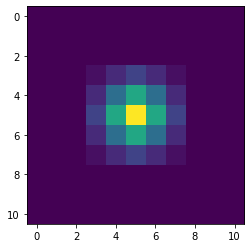

In [158]:
plt.imshow(Z2)

In [134]:
Y

array([[-2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2]])

In [144]:
X2

array([[-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ],
       [-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]])

In [145]:
Y2

array([[-2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ],
       [-1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6],
       [-1.2, -1.2, -1.2, -1.2, -1.2, -1.2, -1.2, -1.2, -1.2, -1.2, -1.2],
       [-0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8],
       [-0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4],
       [ 0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8],
       [ 1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2,  1.2],
       [ 1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6,  1.6],
       [ 2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ,  2. ]])

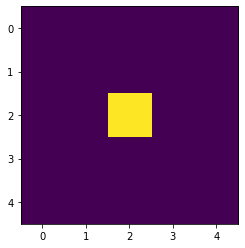

In [150]:
plt.imshow(Z)

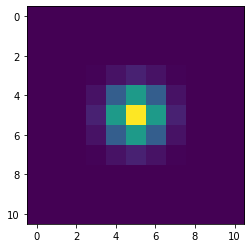

In [152]:
plt.imshow(resize(Z, (11, 11)))

In [170]:
Z2

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.06, 0.1 , 0.06, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.06, 0.18, 0.3 , 0.18, 0.06, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.1 , 0.3 , 0.5 , 0.3 , 0.1 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.06, 0.18, 0.3 , 0.18, 0.06, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.06, 0.1 , 0.06, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [167]:
x = resize(Z, (11, 11), anti_aliasing=False)

In [191]:
x = resize(Z, (11, 11), order=1, anti_aliasing=False)

In [189]:
x.shape

(11, 11)

In [192]:
x

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.00413223, 0.02479339,
        0.04545455, 0.02479339, 0.00413223, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.02479339, 0.14876033,
        0.27272727, 0.14876033, 0.02479339, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.04545455, 0.27272727,
        0.5       , 0.27272727, 0.04545455, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.02479339, 0.

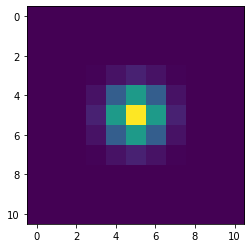

In [193]:
plt.imshow(resize(x, (11, 11)))